### Abstract

In this blog post, we will implement two advanced optimization techniques and compare them. First, we will implement a Newton's Method Optimizer, which uses the Hessian matrix of the data as well as the gradient to update the weight vector. This method can converge very quickly, but it is sensitive to saddle points and struggles with certain datasets. Next, we will implement the Adam Optimizer, which operates on a subset of the data, and therefore can complete updates much more quickly. Because of this, however, the Adam Optimizer needs many more steps to converge. Implementations of these algorithms are located on my Github [here](https://github.com/ellisterling/ellisterling.github.io/blob/main/posts/newton/newton.py). This blog post will aim to compare Newton and Adam and determine how much more efficient Adam can be. Do the faster steps fully offset the need for many more iterations?

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
import torch
import math
import time


### Preliminary Testing of Newton's Method

First, we will take a synthetic dataset and test Newton's Method. This will hopefully eliminate any errors that could occur because of the data, and give us a good indication that our implementation works.

In [2]:
%load_ext autoreload
%autoreload 2
from newton import LogisticRegression, GradientDescentOptimizer, NewtonOptimizer, AdamOptimizer

In [3]:
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X.double(), y.double()

X, y = classification_data(noise = 0.5)

We will create two models: one that uses Newton's Method as the optimizer and one that uses the Gradient Descent Optimizer. We will then compare and check to see that the w vectors they create are approximately similar.

In [4]:
newton = NewtonOptimizer()
loss_arr = []
for _ in range(40):
    loss = newton.loss(X, y)
    loss_arr.append(loss)
    newton.step(X, y, alpha = 0.1)

In [5]:
GD = GradientDescentOptimizer()
loss_arr2 = []
for _ in range(150):
    loss = GD.loss(X, y)
    loss_arr2.append(loss)
    GD.step(X, y, alpha = 0.2, beta = 0)

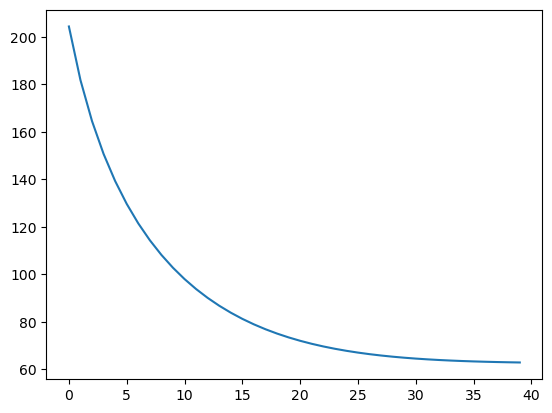

In [6]:
plt.plot(loss_arr)

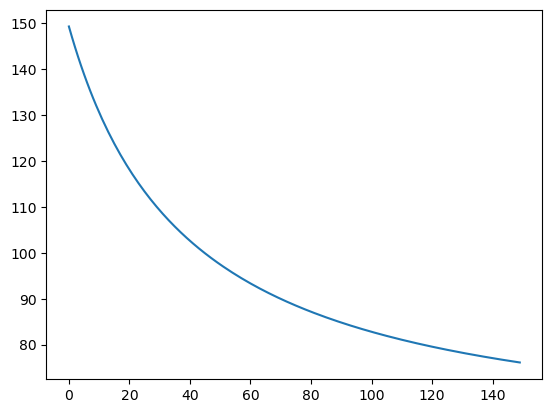

In [7]:
plt.plot(loss_arr2)

They both have converged, so let's plot the w vectors and make sure they are approximately similar.

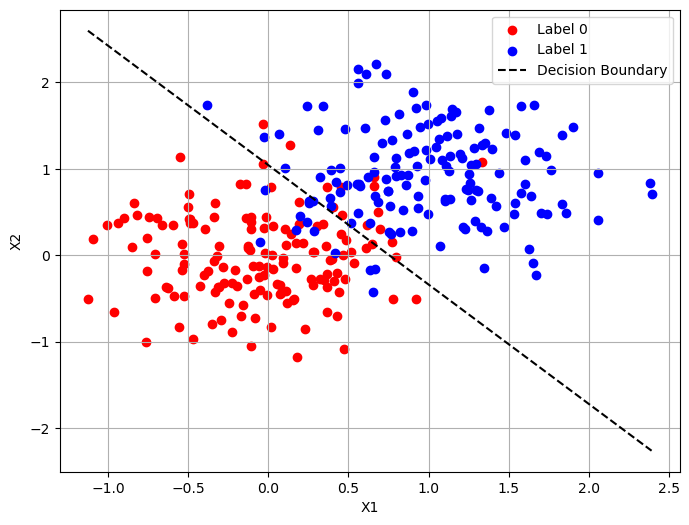

In [8]:
def plot_data_and_w(X, y, w):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='red', label='Label 0')
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', label='Label 1')

    # Decision boundary: w0*x + w1*y + w2 = 0
    x_vals = torch.linspace(X[:, 0].min(), X[:, 0].max(), 100)
    if w[1] != 0:
        y_vals = -(w[0] * x_vals + w[2]) / w[1]
        plt.plot(x_vals, y_vals, 'k--', label='Decision Boundary')

    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_data_and_w(X, y, newton.w)

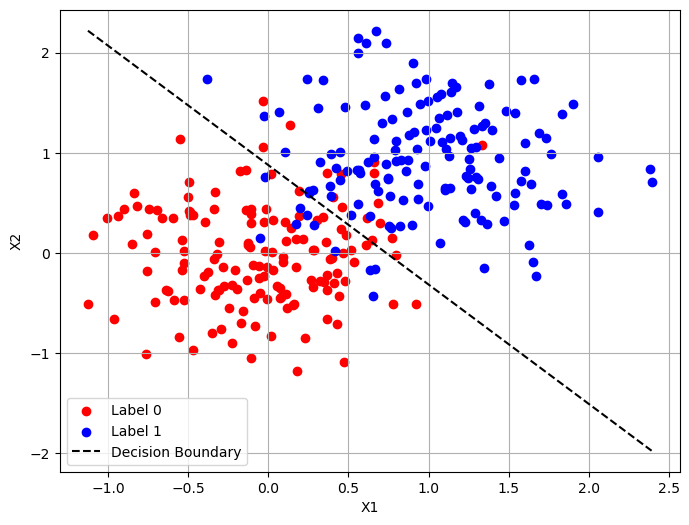

In [9]:
def plot_data_and_w(X, y, w):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='red', label='Label 0')
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', label='Label 1')

    # Decision boundary: w0*x + w1*y + w2 = 0
    x_vals = torch.linspace(X[:, 0].min(), X[:, 0].max(), 100)
    if w[1] != 0:
        y_vals = -(w[0] * x_vals + w[2]) / w[1]
        plt.plot(x_vals, y_vals, 'k--', label='Decision Boundary')

    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_data_and_w(X, y, GD.w)

In [10]:
print(newton.w, GD.w)

tensor([ 3.8513,  2.7875, -2.9071], dtype=torch.float64) tensor([ 2.0984,  1.7615, -1.5457], dtype=torch.float64)


We can see that although the w vectors are slightly different, they both separate the data pretty well. This could also be because Newton converged much more quickly than Gradient Descent, and therefore Gradient Descent could possibly converge slightly more and meet the w values for Newton.

### Newton's Method Experiments

It took me a long time to find a dataset that worked well for Newton's method. Since the step function finds the inverse of the Hessian Matrix, I was running into issues where the Hessian was singular and therefore could not be inverted. I therefore switched to using torch.pinverse so that the loop would continue to run. This did result in some NaN values in the loss array.

The data we'll be using is data on Titanic passengers and whether or not they survived. This dataset was obtained from [Kaggle](https://www.kaggle.com/datasets/yasserh/titanic-dataset).

First, I read in the data and did some visualizations to better understand the features included.

In [11]:
df = pd.read_csv("/Users/ellisterling/Documents/spring25/csci0451/ellisterling.github.io/posts/newton/data/Titanic-Dataset.csv")
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

Here I chose a subset of the features based on both plotting and running the algorithm to see what affected accuracy.

In [12]:
filter = ["Pclass", "Sex", "Age", "Fare", "Survived"]

One such plot was a count plot of the class that the passengers were in, with separate bars for those who survived and those who didn't. We can see here that there were many more passengers in third class. First class was most likely to survive, second class was about half and half, and the vast majority of people in third class passed away.

<Axes: xlabel='Pclass', ylabel='count'>

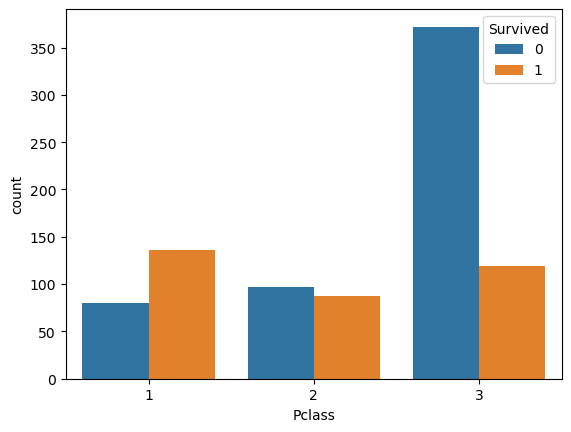

In [13]:
sns.countplot(df, x = "Pclass", hue = "Survived")

We can also check the number of people who survived versus didn't. Below, we can see that less than half the passengers survived.

In [14]:
df.groupby("Survived")["Survived"].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

Now we are going to process the data to get it into tensor form so the Newton and Adam Optimizers can hande it.

In [15]:
df = df[filter]
df = df.dropna()
df = pd.get_dummies(df)

Train test split!

In [16]:
df_train, df_test = train_test_split(df, test_size = 0.3)
X_train = df_train.drop("Survived", axis=1)
y_train = df_train["Survived"]
X_test = df_test.drop("Survived", axis=1)
y_test = df_test["Survived"]

In [17]:
X_train_tensor = torch.from_numpy(X_train.to_numpy().astype(float))
X_test_tensor = torch.from_numpy(X_test.to_numpy().astype(float))
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float)


In [18]:
X_train_tensor = X_train_tensor.double()
X_train_tensor
y_train_tensor = y_train_tensor.double()
X_test_tensor = X_test_tensor.double()
y_test_tensor = y_test_tensor.double()

Now we can run experiments on this data with the Newton Optimizer.

In [19]:
w_dims = X_train_tensor.size()[1]

In [20]:
newton = NewtonOptimizer()
loss_arr3 = []

In [21]:
newton_start_time = time.time()
loss = math.inf
while loss >= 240 or torch.isnan(loss):
    loss = newton.loss(X_train_tensor, y_train_tensor)
    loss_arr3.append(loss)
    newton.step(X_train_tensor, y_train_tensor, alpha = 0.01)
newton_end_time = time.time()

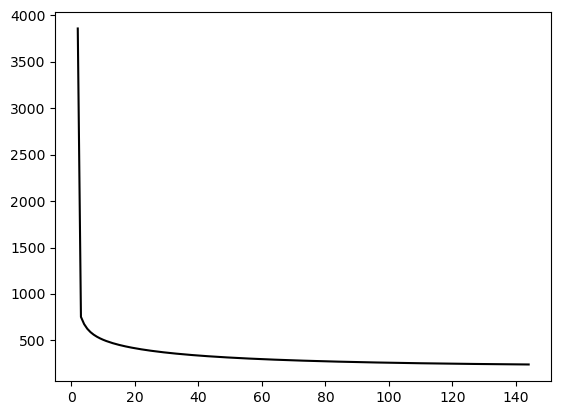

In [22]:
plt.plot(torch.arange(1, len(loss_arr3)+1), loss_arr3, color = "black")

Inspect the weight vector:

In [23]:
newton.w

tensor([-7.6022e-01, -3.8174e-02, -8.3349e-04,  3.2181e+00,  1.4790e+00],
       dtype=torch.float64)

In [24]:
y_test_tensor

tensor([0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1.,
        1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0.,
        0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
        1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1.,
        1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
        0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.],
       dtype=torch.float64)

In [25]:
predicted = newton.predict(X_test_tensor)
predicted

tensor([0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
        1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1.,
        1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0.,
        1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.])

Let's check the accuracy:

In [26]:
#find score
(predicted == y_test_tensor).sum()/len(predicted)

tensor(0.7674)

Pretty good! It would be hard to visualize a 5d vector like this on a plot as we did with the synthetic data, but the score on our data is pretty good. Let's look at the confusion matrix too:

In [27]:
#find confusion matrix
from sklearn.metrics import confusion_matrix
C = confusion_matrix(y_test_tensor, predicted)
C

array([[119,  11],
       [ 39,  46]])

We have slightly higher error rate for passengers who survived. Now, let's make an example where alpha is too large and Newton's method fails to converge.

In [28]:
newton = NewtonOptimizer()
loss_arr = []

In [29]:
loss = torch.inf
while loss >= 240 or torch.isnan(loss):
    loss = newton.loss(X_train_tensor, y_train_tensor)
    loss_arr.append(loss)
    newton.step(X_train_tensor, y_train_tensor, alpha = 0.5)

KeyboardInterrupt: 

We let the model run for a minute and it didn't converge.

In [30]:
predicted = newton.predict(X_test_tensor)
(predicted == y_test_tensor).sum()/len(predicted)

tensor(0.6000)

We can also see that it didn't reach the level of accuracy it was reaching before.

### Adam Optimizer Experiments

In [33]:
adam = AdamOptimizer()
adam_loss = []

In [34]:
adam_start_time = time.time()
t = 1
loss = torch.inf
while loss >= 240 or torch.isnan(loss):
    loss = adam.loss(X_train_tensor, y_train_tensor)
    adam_loss.append(loss)
    adam.step(X_train_tensor, y_train_tensor, 10, 0.01, 0.9, 0.999, t)
    t += 1
adam_end_time = time.time()

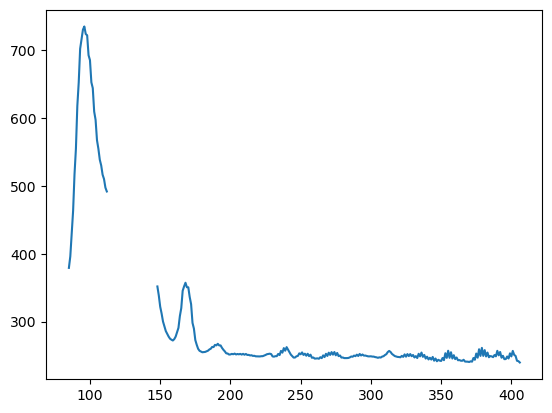

In [35]:
plt.plot(adam_loss)

In [36]:
predicted = adam.predict(X_test_tensor)
(predicted == y_test_tensor).sum()/len(predicted)

tensor(0.7721)

Great! We are able to obtain similar accuracy by predicting with Adam to Newton. Now, let's compare against standard minibatch stochastic gradient descent. I did this by selecting a batch in the loop, and using my standard gradient descent model from the Logistic Regression blog post.

In [37]:
sgd = GradientDescentOptimizer()
sgd_loss = []
t = 1
loss = torch.inf
batch_size = 10
while loss >= 240 or torch.isnan(loss):
    i = torch.randint(0, len(y_train_tensor), (batch_size,))
    loss = sgd.loss(X_train_tensor, y_train_tensor)
    sgd_loss.append(loss)
    sgd.step(X_train_tensor[i], y_train_tensor[i], 0.01, 0.9)

KeyboardInterrupt: 

We ran it for a minute and still it never reached a loss of 240. Let's take a look at the loss plot:

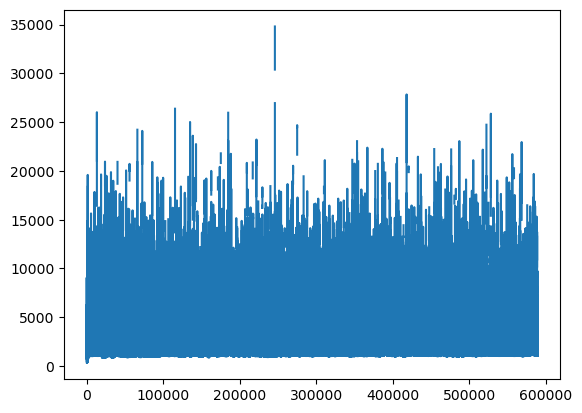

In [38]:
plt.plot(sgd_loss)

Clearly, at this step size (.01), SGD does not converge. Let's try with some smaller timesteps.

In [39]:
adam = AdamOptimizer()
adam_loss = []

In [40]:
t = 1
loss = torch.inf
while loss >= 240 or torch.isnan(loss):
    loss = adam.loss(X_train_tensor, y_train_tensor)
    adam_loss.append(loss)
    adam.step(X_train_tensor, y_train_tensor, 10, 0.0001, 0.9, 0.999, t)
    t += 1

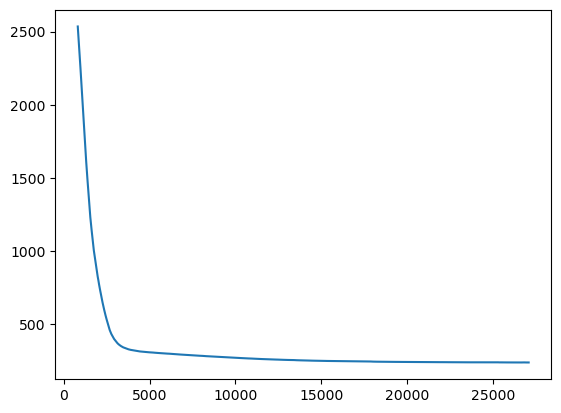

In [41]:
plt.plot(adam_loss)

In [42]:
sgd = GradientDescentOptimizer()
sgd_loss = []
t = 1
loss = torch.inf
batch_size = 10
while loss >= 240 or torch.isnan(loss):
    i = torch.randint(0, len(y_train_tensor), (batch_size,))
    loss = sgd.loss(X_train_tensor, y_train_tensor)
    sgd_loss.append(loss)
    sgd.step(X_train_tensor[i], y_train_tensor[i], 0.0001, 0.9)

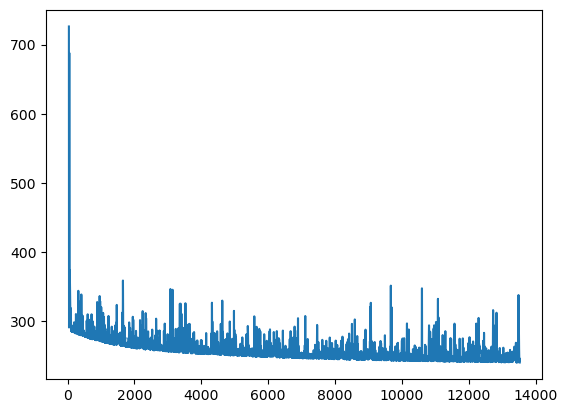

In [43]:
plt.plot(sgd_loss)

The plot looks a little weirder than the Adam plot, but it certainly converges. It also completed its training loop in .1 seconds, whereas Adam completed its training loop in 1.6 seconds.

SGD performs faster with smaller steps, but fails to converge at larger steps. Adam converges more reliably, but takes a longer time with smaller step sizes (e.g. .0001).

### Newton and Adam Comparison

In the sections above, we ran Newton and Adam optimizers until the loss reached 240, which seemed to be about where they converged for this dataset. Adam took more iterations, but frequently beat out Newton in terms of time taken to run to convergence. On occasion, Newton would beat Adam, but this likely depended on the train-test split of the data and the initial choice of the weight vector w for both optimizers. When run with a step size of .01, these were their times:

In [44]:
adam_time = adam_end_time - adam_start_time
newton_time = newton_end_time - newton_start_time
print(f"Newton Time: {newton_time}\nAdam Time: {adam_time}")

Newton Time: 0.10831212997436523
Adam Time: 0.06185793876647949


Generally, it seems that Adam is much faster, even though it takes more iterations to reach convergence. However, depending on the train-test split and the initial choice of w, Newton may perform better. Both Adam and Newton perform best with small step sizes.

### Discussion

Overall, running these experiments showed me that the optimizer that performs the best is heavily dependent on the dataset and the step size. One thing that interested me about this is how increasing complexity of the optimizer/implementing a more advanced method means that, in some ways, we are sacrificing reliability of convergence. However, these more advanced methods can handle more complex datasets than classic gradient descent. I was also interested that the train-test split and the choice of initial w vectors drastically affected the time and iterations that it took Newton and Adam to converge. Overall, it seemed that Adam was faster, but Newton could overtake it a lot of the time. I would be interested to try these optimizers on a bunch of datasets to get better context for which one has overall better performance.